## Import

In [ ]:
import torch
import numpy as np
from glob import glob
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torchsummary import summary
from PIL import Image
import os
import re
import nibabel as nib

In [ ]:
# Top level data directory. Here we assume the format of the directory conforms
#   to the ImageFolder structure

# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception]

# Number of classes in the dataset
num_classes = 1

# Batch size for training (change depending on how much memory you have)
batch_size = 8

# Number of epochs to train for
num_epochs = 50

# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params
feature_extract = True

## Data Load

In [ ]:
import zipfile
zip_file = zipfile.ZipFile('/content/drive/MyDrive/chest_xray.zip')
zip_file.extractall('/content/datasets')
zip_file.close()

In [ ]:
PATH = '/content/datasets/chest_xray/'

from glob import glob

normal_train_data = glob(PATH + 'train/NORMAL/*.jpeg')
pneumonia_train_data = glob(PATH + 'train/PNEUMONIA/*.jpeg')
normal_val_data = glob(PATH + 'val/NORMAL/*.jpeg')
pneumonia_val_data = glob(PATH + 'val/PNEUMONIA/*.jpeg')
normal_test_data = glob(PATH + 'test/NORMAL/*.jpeg')
pneumonia_test_data = glob(PATH + 'test/PNEUMONIA/*.jpeg')

In [ ]:
train_path  = normal_train_data + pneumonia_train_data
val_path = normal_val_data + pneumonia_val_data
test_path = normal_test_data + pneumonia_test_data

In [ ]:
len(train_path)

5216

In [ ]:
len(test_path)

624

In [ ]:
sample_image = np.array(Image.open(train_path[0]))
sample_image = sample_image[:,:,np.newaxis]
sample_image.shape

(1484, 1756, 1)

In [ ]:
_label = train_path[0].split('/')[-2]

In [ ]:
sample_image = np.concatenate((sample_image,sample_image,sample_image),axis=-1)

In [ ]:
len(sample_image.shape)

3

## Data Load

In [ ]:
classes = ['NORMAL','PNEUMONIA']

In [ ]:
def get_label(path):
    lbl_name = path.split('/')[-2]
    label = np.argmax(classes == lbl_name)
    return label

In [ ]:
class2idx = {cls:idx for idx, cls in enumerate(classes)}
class2idx

{'NORMAL': 0, 'PNEUMONIA': 1}

In [ ]:
len(train_path)

5216

In [ ]:
get_label(train_path[4156])

0

In [ ]:
class Train_Dataset(Dataset):
    def __init__(self, data_path,transform = None):
        self.data_path = data_path
        self.transform = transform
    def __len__(self):
        return len(self.data_path)
    def __getitem__(self,idx):
        path = self.data_path[idx]
        img = Image.open(path)
        img = np.squeeze(np.array(img.resize((416,416))))
        img = img/255
        if len(img.shape) == 2:
          img = img[:,:,np.newaxis]
          img = np.concatenate((img,img,img), axis = -1)
        else:
          pass
        label = path.split('/')[-2]
        label = class2idx[label]
        if self.transform is not None:
            transformed = self.transform(image=img)
            image = transformed['image']
        
        return image.float(), label

In [ ]:
class val_Dataset(Dataset):
    def __init__(self, data_path,transform = None):
        self.data_path = data_path
        self.transform = transform
    def __len__(self):
        return len(self.data_path)
    def __getitem__(self,idx):
        path = self.data_path[idx]
        img = Image.open(path)
        img = np.squeeze(np.array(img.resize((416,416))))
        img = img/255
        if len(img.shape) == 2:
          img = img[:,:,np.newaxis]
          img = np.concatenate((img,img,img), axis = -1)
        else:
          pass
        label = path.split('/')[-2]
        label = class2idx[label]
        if self.transform is not None:
            transformed = self.transform(image=img)
            image = transformed['image']
        return image, label

In [ ]:
class test_Dataset(Dataset):
    def __init__(self, data_path,transform = None):
        self.data_path = data_path
        self.transform = transform
    def __len__(self):
        return len(self.data_path)
    def __getitem__(self,idx):
        path = self.data_path[idx]
        img = Image.open(path)
        img = np.squeeze(np.array(img.resize((416,416))))
        img = img/255
        if len(img.shape) == 2:
          img = img[:,:,np.newaxis]
          img = np.concatenate((img,img,img), axis = -1)
        else:
          pass
        label = path.split('/')[-2]
        label = class2idx[label]
        if self.transform is not None:
            transformed = self.transform(image=img)
            image = transformed['image']
        return image, label

In [ ]:
#!pip install --upgrade --force-reinstall --no-deps albumentations
#!pip install albumentations==0.4.6

In [ ]:
import albumentations as A                                                                           
from albumentations.pytorch import ToTensorV2

In [ ]:
train_transform = A.Compose(
    [
      ToTensorV2()
     ]
    )

test_transform = A.Compose([
     ToTensorV2()
                            ]
                           )

val_transform = A.Compose([
     ToTensorV2()
                            ]
                           )

In [ ]:
train_data = Train_Dataset(train_path,transform = train_transform)
val_data = val_Dataset(val_path,transform = val_transform)
test_data = val_Dataset(test_path,transform = test_transform)

In [ ]:
train_loader = torch.utils.data.DataLoader(
    train_data,
    batch_size = batch_size,
    shuffle = True,
)
val_loader = torch.utils.data.DataLoader(
    val_data,
        batch_size = batch_size,
    shuffle = False,
)
test_loader = torch.utils.data.DataLoader(
    test_data,
        batch_size = batch_size,
    shuffle = False,
)

## Model

In [ ]:
model = torch.hub.load('pytorch/vision:v0.10.0','resnet101',pretrained= True)

Downloading: "https://github.com/pytorch/vision/archive/v0.10.0.zip" to /root/.cache/torch/hub/v0.10.0.zip
Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth


  0%|          | 0.00/171M [00:00<?, ?B/s]

In [ ]:
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

In [ ]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False):
    since = time.time()

    val_acc_history = []
    train_acc_history = []
    train_loss_hist = []
    val_loss_hist = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            start = time.time()
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device = device, dtype = torch.float32)
                labels = labels.to(device = device)
                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            if phase == 'train':
              train_acc_history.append(epoch_acc)
              train_loss_hist.append(epoch_loss)
            print('{} Loss: {:.4f} Acc: {:.4f}, Time : {:.4f}'.format(phase, epoch_loss, epoch_acc, time.time()-start))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)
                val_loss_hist.append(epoch_loss)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, train_loss_hist, train_acc_history, val_loss_hist ,val_acc_history

In [ ]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [ ]:
def initialize_model(model_ft, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    set_parameter_requires_grad(model_ft, feature_extract)
    # Handle the primary net
    num_ftrs = model_ft.fc.in_features
    model_ft.fc = nn.Linear(num_ftrs,num_classes)
    input_size = 299
    return model_ft, input_size

In [ ]:
feature_extract = True

In [ ]:
model_ft, input_size = initialize_model(model, 2, feature_extract, use_pretrained=True)

In [ ]:
summary(model_ft.to('cuda'),(3,416,416))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 208, 208]           9,408
       BatchNorm2d-2         [-1, 64, 208, 208]             128
              ReLU-3         [-1, 64, 208, 208]               0
         MaxPool2d-4         [-1, 64, 104, 104]               0
            Conv2d-5         [-1, 64, 104, 104]           4,096
       BatchNorm2d-6         [-1, 64, 104, 104]             128
              ReLU-7         [-1, 64, 104, 104]               0
            Conv2d-8         [-1, 64, 104, 104]          36,864
       BatchNorm2d-9         [-1, 64, 104, 104]             128
             ReLU-10         [-1, 64, 104, 104]               0
           Conv2d-11        [-1, 256, 104, 104]          16,384
      BatchNorm2d-12        [-1, 256, 104, 104]             512
           Conv2d-13        [-1, 256, 104, 104]          16,384
      BatchNorm2d-14        [-1, 256, 1

In [ ]:
model_ft.fc

Linear(in_features=2048, out_features=2, bias=True)

In [ ]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

print("Initializing Datasets and Dataloaders...")

# Create training and validation datasets
# Create training and validation dataloaders
dataloaders_dict = {'train' : train_loader , 'val' : val_loader}

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Initializing Datasets and Dataloaders...


In [ ]:
model_ft = model_ft.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = [] # 파라미터 리스트 생성
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9) # 업데이트 할 파라미터만 넣어준다.

Params to learn:
	 fc.weight
	 fc.bias


In [ ]:
criterion = nn.CrossEntropyLoss().cuda()

# Train and evaluate
model_ft, train_loss, train_acc, val_loss, val_acc = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs, is_inception= True)

Epoch 0/49
----------
train Loss: 0.2818 Acc: 0.8786, Time : 143.1774
val Loss: 0.9004 Acc: 0.6250, Time : 0.4395

Epoch 1/49
----------
train Loss: 0.2206 Acc: 0.9103, Time : 143.4069
val Loss: 1.4014 Acc: 0.5000, Time : 0.4515

Epoch 2/49
----------
train Loss: 0.1897 Acc: 0.9262, Time : 143.3492
val Loss: 0.5549 Acc: 0.6875, Time : 0.4493

Epoch 3/49
----------
train Loss: 0.2079 Acc: 0.9162, Time : 143.4009
val Loss: 0.6996 Acc: 0.6875, Time : 0.4511

Epoch 4/49
----------
train Loss: 0.1777 Acc: 0.9260, Time : 143.1906
val Loss: 0.5752 Acc: 0.6875, Time : 0.4421

Epoch 5/49
----------
train Loss: 0.1775 Acc: 0.9283, Time : 143.4698
val Loss: 0.3381 Acc: 0.7500, Time : 0.4419

Epoch 6/49
----------
train Loss: 0.1631 Acc: 0.9352, Time : 143.4334
val Loss: 0.4131 Acc: 0.7500, Time : 0.4361

Epoch 7/49
----------
train Loss: 0.1721 Acc: 0.9293, Time : 143.3018
val Loss: 0.1662 Acc: 0.9375, Time : 0.4430

Epoch 8/49
----------
train Loss: 0.1621 Acc: 0.9379, Time : 143.3591
val Loss: 

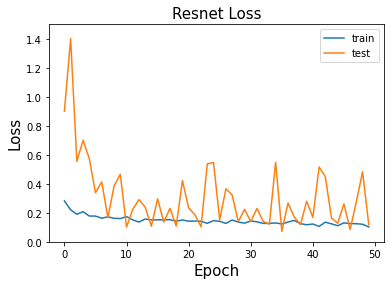

In [ ]:
plt.plot(train_loss)
plt.plot(val_loss)
plt.title('Resnet Loss', fontsize = 15)
plt.xlabel('Epoch', fontsize = 15)
plt.ylabel('Loss', fontsize = 15)
plt.ylim(0,1.5)
plt.legend(['train','val'], loc='upper right')
plt.show()

In [ ]:
train_accuracy = []
val_accuracy = []
for i in range(len(train_acc)):
  train_accuracy.append(train_acc[i].to('cpu').numpy())
for i in range(len(val_acc)):
  val_accuracy.append(val_acc[i].to('cpu').numpy())

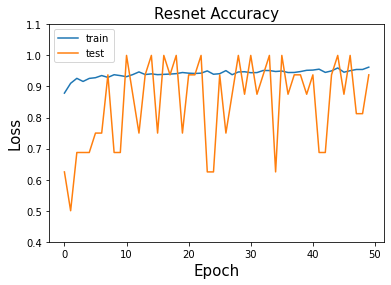

In [ ]:
plt.plot(train_accuracy)
plt.plot(val_accuracy)
plt.title('Resnet Accuracy', fontsize = 15)
plt.xlabel('Epoch', fontsize = 15)
plt.ylabel('Accuracy', fontsize = 15)
plt.ylim(0.4,1.1)
plt.legend(['train','val'], loc='upper left')
plt.show()

In [ ]:
torch.save(model_ft, '/content/drive/MyDrive/Colab Notebooks/sample_resnet_pneumonia_model')

In [ ]:
test_loader

624

In [ ]:

running_loss = 0.0
running_corrects = 0
start = time.time()
for inputs, labels in test_loader:
    inputs = inputs.to(device = device, dtype = torch.float32)
    labels = labels.to(device = device)
    # zero the parameter gradients
    optimizer_ft.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    _, preds = torch.max(outputs, 1)
    running_loss += loss.item() * inputs.size(0)
    running_corrects += torch.sum(preds == labels.data)
    epoch_loss = running_loss / len(test_loader.dataset)
    epoch_acc = running_corrects.double() / len(test_loader.dataset)
print('Test Loss: {:.4f} Acc: {:.4f}, Time : {:.4f}'.format(epoch_loss, epoch_acc, time.time()-start))

Test Loss: 0.3007 Acc: 0.8990, Time : 17.1100
